This notebook runs experiments on comparing the difference between time used by three forking methods

1. Copying a coroutine
2. Copying a process
3. Replaying a coroutine

by [**Kai Xu**](http://xukai92.github.io/) on **07/10/2016**

Let's start by loading some essential packages: `Gadfly` for plotting and aimed forking methods from `Turing`.

In [2]:
using Gadfly, DataFrames
import Turing: TraceC, TraceR, fork

Functions below are used to compute statics for plotting

In [3]:
function stds(times)
    map(v -> std([Float64(t) for t in v]), times)
end

function means(times)
    map(v -> mean(v), times)
end;

It would be straightforward to run the experiment on an array versin of Fibonaaci, which is defined as below.

In [5]:
function fib_stack()
    stack = Array{Int}(depth_max)
    ith = 1
    while true
        if ith == 1 || ith == 2
            stack[ith] = 1
        else
            stack[ith] = stack[ith - 1] + stack[ith - 2]
        end
        produce(stack[ith])
    end
end

fib_stack (generic function with 1 method)

In [157]:
depth_max = 1000
num = 10

coroutine_times = Array{Vector}(depth_max)
for i = 1:depth_max
    coroutine_times[i] = Vector(num)
end

for n = 1:num
    trace = TraceC(fib_stack)
    for depth = 1:depth_max
        coroutine_times[depth][n] = @elapsed fork(trace)
        consume(trace)
    end
end

coroutine_times = coroutine_times .* 1000

replaying_times = Array{Vector}(depth_max)
for i = 1:depth_max
    replaying_times[i] = Vector(num)
end

for n = 1:num
    trace = TraceR(fib_stack)
    for depth = 1:depth_max
        replaying_times[depth][n] = @elapsed fork(trace)
        consume(trace)
    end
end
replaying_times = replaying_times .* 1000;

Read and convert DataFrame to Array of Vector

In [155]:
process_times = Array{Vector}(depth_max)
for i = 1:depth_max
    process_times[i] = Vector(num)
end

for n = 1:num
    df = readtable("./fork/array$n.csv", separator = ';', header = false)

    for i = 1:depth_max
        process_times[i][n] = Vector([t for t in convert(Array, df[i,:])])[1] .* 1000
    end
end

And same, the plot.

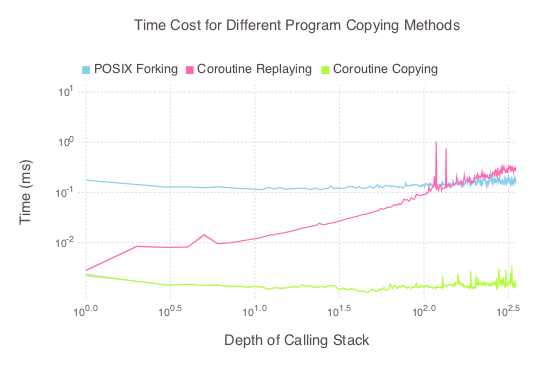

In [195]:
replaying_times = Array{Vector}(depth_max)
for i = 1:depth_max
    replaying_times[i] = Vector(num)
end

for n = 1:num
    trace = TraceR(fib_stack)
    for depth = 1:depth_max
        replaying_times[depth][n] = @elapsed fork(trace)
        consume(trace)
    end
end
replaying_times = replaying_times .* 1000;

coroutine_means = means(coroutine_times)
coroutine_stds = stds(coroutine_times)
coroutine_mins = coroutine_means .- (1.96 * coroutine_stds / sqrt(depth_max))
coroutine_maxs = coroutine_means .+ (1.96 * coroutine_stds / sqrt(depth_max))

coroutine_layer = layer(
    x=1:depth_max, y=coroutine_means, ymin=coroutine_mins, ymax=coroutine_maxs, Geom.line, Geom.ribbon,
    Theme(default_color=colorant"greenyellow")
)

replaying_means = means(replaying_times)
replaying_stds = stds(replaying_times)
replaying_mins = replaying_means - (1.96 * replaying_stds / sqrt(depth_max))
replaying_maxs = replaying_means + (1.96 * replaying_stds / sqrt(depth_max))

replaying_layer = layer(
    x=1:depth_max, y=replaying_means, ymin=replaying_mins, ymax=replaying_maxs, Geom.line, Geom.ribbon,
    Theme(default_color=colorant"hotpink")
)

process_means = means(process_times)
process_stds = stds(process_times)
process_mins = process_means - (1.96 * process_stds / sqrt(depth_max))
process_maxs = process_means + (1.96 * process_stds / sqrt(depth_max))

process_layer = layer(
    x=1:depth_max, y=process_means, ymin=process_mins, ymax=process_maxs, Geom.line, Geom.ribbon,
    Theme(default_color=colorant"skyblue")
)

p_stack = plot(
    coroutine_layer, replaying_layer, process_layer,
    
Guide.xlabel("Depth of Calling Stack"), Guide.ylabel("Time (ms)"),
Guide.title("Time Cost for Different Program Copying Methods"),
Guide.manual_color_key(
"",["POSIX Forking   ","Coroutine Replaying   ", "Coroutine Copying"], 
["skyblue", "hotpink", "greenyellow"]),
    Theme(key_position=:top, key_label_font_size=9.5pt),
Scale.x_log10, Scale.y_log10, Coord.Cartesian(xmax=2.5, ymax=1), 
)
# intersection ~ 150

And again save the plot.

In [183]:
draw(PDF("exp2array.pdf", 5inch, 3.75inch), p_stack)

> Environment:
- OS: macOS Sierra v10.12
- Machine: MacBook Pro (Retina, 13-inch, Late 2013)
- Processor: 2.4 GHz Intel Core i5
- Memory: 8 GB 16000 MHz DDR3
- Graphics:Intel Iris 1536 MB

> Note: the limit of the number of child processes could be forked by users on macOS from C is 709.